# Extraer espetrogramas

In [1]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets, utils
from PIL import Image
import numpy as np
import math
from IPython.display import display
from tqdm import tqdm
from itertools import cycle
from typing import Tuple

%pip install opencv-python librosa numpy matplotlib
%pip install ipywidgets
import cv2
import librosa
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Defining the Hyper-parameters**

We now define the hyperparameters that are going to be used throughout the notebook to define the network.


In [41]:
hparams = {
    'batch_size': 1,
    'num_epochs': 5,
    'learning_rate': 0.00001,
    'betas': (0.5, 0.999),
    'num_val_samples': 4,
    'input_channels': 4,
    'output_channels': 3,
    'use_generated_frames_prob' : 0.5
}

### Dataset and Data Loader
Download and prepare dataset and datalaoder


In [6]:
import os
from torch.utils.data import Dataset, DataLoader

# Change directory to the folder containing the videos
os.chdir(r'C:/Users/David/Documents/postgrau/Projecte/raining')

# Get a list of all .mp4 files in the folder
video_files = [f for f in os.listdir('.') if f.endswith('.mp4')]

# Create the 'frames' directory if it doesn't exist
if not os.path.exists('frames'):
    os.makedirs('frames')

# Loop through each video file
for video_file in video_files:
    # Load the video
    cap = cv2.VideoCapture(video_file)

    # Initialize frame and spectrogram lists
    frames = []
    spectrograms = []

    # Get the total duration of the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_duration = total_frames / fps

    # Extract frames and spectrograms
    frame_time = 0  # initialize frame time to 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame to 128x128
        frame = cv2.resize(frame, (256, 256))

        # Extract audio and convert to spectrogram
        # Load a short segment of audio centered around the current frame

        # Pad the audio appropriately for the first and last frames
        if frame_time < 0.5:
            # For the first frames, load audio from the start and pad the beginning
            padding_duration = 0.5 - frame_time
            y, sr = librosa.load(video_file, sr=None, offset=0, duration=frame_time + 0.5)
            y_padded = np.pad(y, (int(sr * padding_duration), 0), 'constant')
        elif frame_time > total_duration - 0.5:
            # For the last frames, load audio from the end and pad the end
            padding_duration = 0.5 - (total_duration - frame_time)
            audio_offset = frame_time - 0.5
            y, sr = librosa.load(video_file, sr=None, offset=audio_offset, duration=1 - padding_duration)
            y_padded = np.pad(y, (0, int(sr * padding_duration)), 'constant')
        else:
            # For all other frames, load 1 second of audio as before
            y, sr = librosa.load(video_file, sr=None, offset=frame_time - 0.5, duration=1)
            y_padded = y

        win_length = 256  # window length in samples
        hop_length = 64  # hop length in samples
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y_padded, win_length=win_length, hop_length=hop_length)), ref=np.max)

        # Resize spectrogram to 128x128
        D = cv2.resize(D, (256, 256))

        spectrograms.append(D)

        # Save frame and spectrogram to the 'frames' directory using the frame time as the filename
        frame_filename = 'frames/{}_{:.3f}_frame.npy'.format(video_file.split('.')[0], frame_time)
        spectrogram_filename = 'frames/{}_{:.3f}_spectrogram.npy'.format(video_file.split('.')[0], frame_time)
        np.save(frame_filename, frame)
        np.save(spectrogram_filename, spectrograms[-1])

        print(f'Saved {frame_filename} and {spectrogram_filename}')

        frames.append(frame)
        frame_time += 1 / fps  # increment frame time by the duration of one frame

    cap.release()

# Ensure the 'results' directory exists
os.makedirs('results', exist_ok=True)

# Rest of the code for DataLoader, model definition, and training loop...




KeyboardInterrupt: 

In [28]:
# Change directory to the folder containing the frames and spectrograms
os.chdir('C:/Users/David/Documents/postgrau/Projecte/raining/frames')

import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    

class TimeMasking(object):
    def __init__(self, max_mask_size):
        self.max_mask_size = max_mask_size

    def __call__(self, tensor):
        time_mask_size = np.random.randint(0, self.max_mask_size)
        time_mask_start = np.random.randint(0, tensor.size(2) - time_mask_size)
        tensor[:, :, time_mask_start:time_mask_start + time_mask_size] = 0
        return tensor

class FrequencyMasking(object):
    def __init__(self, max_mask_size):
        self.max_mask_size = max_mask_size

    def __call__(self, tensor):
        freq_mask_size = np.random.randint(0, self.max_mask_size)
        freq_mask_start = np.random.randint(0, tensor.size(1) - freq_mask_size)
        tensor[:, freq_mask_start:freq_mask_start + freq_mask_size, :] = 0
        return tensor


class FrameSpectrogramDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.frame_files = sorted([f for f in os.listdir(root_dir) if f.endswith('_frame.npy')])
        
        # Define the transformations
        self.transformS = transforms.Compose([
            transforms.RandomApply([AddGaussianNoise(0., 2)], p=0.3),
            transforms.RandomApply([transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0))], p=0.5),
            transforms.RandomApply([FrequencyMasking(max_mask_size=10)], p=0.2),
        ])

        self.transformF = transforms.Compose([
            transforms.RandomApply([AddGaussianNoise(0., 1)], p=0.5),
            transforms.RandomApply([transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0))], p=0.5),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.5)
        ])

    def __len__(self):
        return len(self.frame_files)

    def __getitem__(self, idx):
        frame_file = self.frame_files[idx]
        frame = np.load(os.path.join(self.root_dir, frame_file))
        spectrogram_file = frame_file.replace('_frame.npy', '_spectrogram.npy')
        spectrogram = np.load(os.path.join(self.root_dir, spectrogram_file))

        # Get the previous frame
        if idx > 0:
            prev_frame_file = self.frame_files[idx - 1]
            prev_frame = np.load(os.path.join(self.root_dir, prev_frame_file))
        else:
            prev_frame = np.zeros_like(frame)  # Use a zero array if there is no previous frame

        # Convert numpy arrays to PyTorch tensors with the same data type
        frame = torch.from_numpy(frame.astype(np.float32)).permute(2, 0, 1)
        prev_frame = torch.from_numpy(prev_frame.astype(np.float32)).permute(2, 0, 1)
        spectrogram = torch.from_numpy(spectrogram.astype(np.float32)).unsqueeze(0)  # Add channel dimension

        # Apply transformations
        prev_frame = self.transformF(prev_frame)
        spectrogram = self.transformS(spectrogram)

        # Normalize to [-1, 1]
        frame = (frame / 127.5) - 1
        prev_frame = (prev_frame / 127.5) - 1
        spectrogram = (spectrogram / 127.5) - 1

        return frame, prev_frame, spectrogram


# Create a dataset
dataset = FrameSpectrogramDataset('.')

# Calculate the split index
dataset_size = len(dataset)
split_index = int(0.9 * dataset_size)

# Create training and validation subsets
train_indices = list(range(split_index))
val_indices = list(range(split_index, dataset_size))

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create DataLoaders
dataloader = DataLoader(
    train_dataset,
    batch_size=hparams['batch_size'],
    shuffle=True,  # Shuffle the training set
)

val_loader = DataLoader(
    val_dataset,
    batch_size=hparams['batch_size'],
    shuffle=False,  # Do not shuffle the validation set
)

In [29]:
dataset = FrameSpectrogramDataset('.')
print(len(dataset))

17969


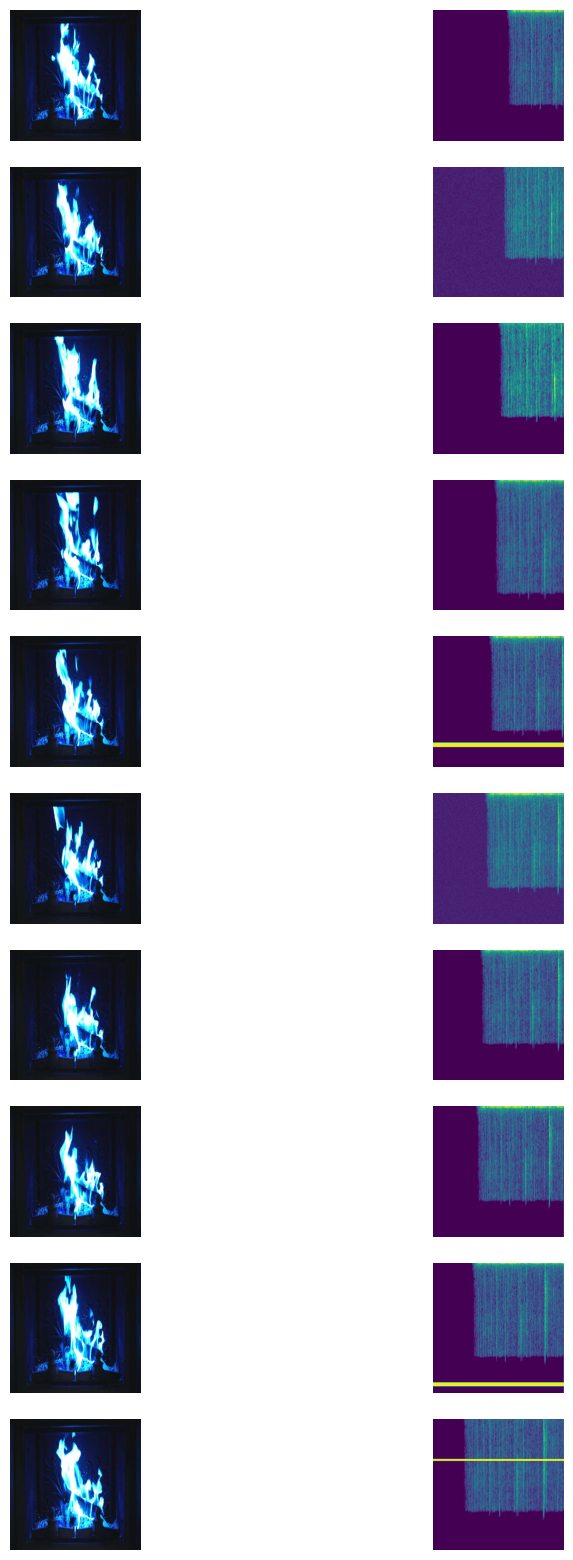

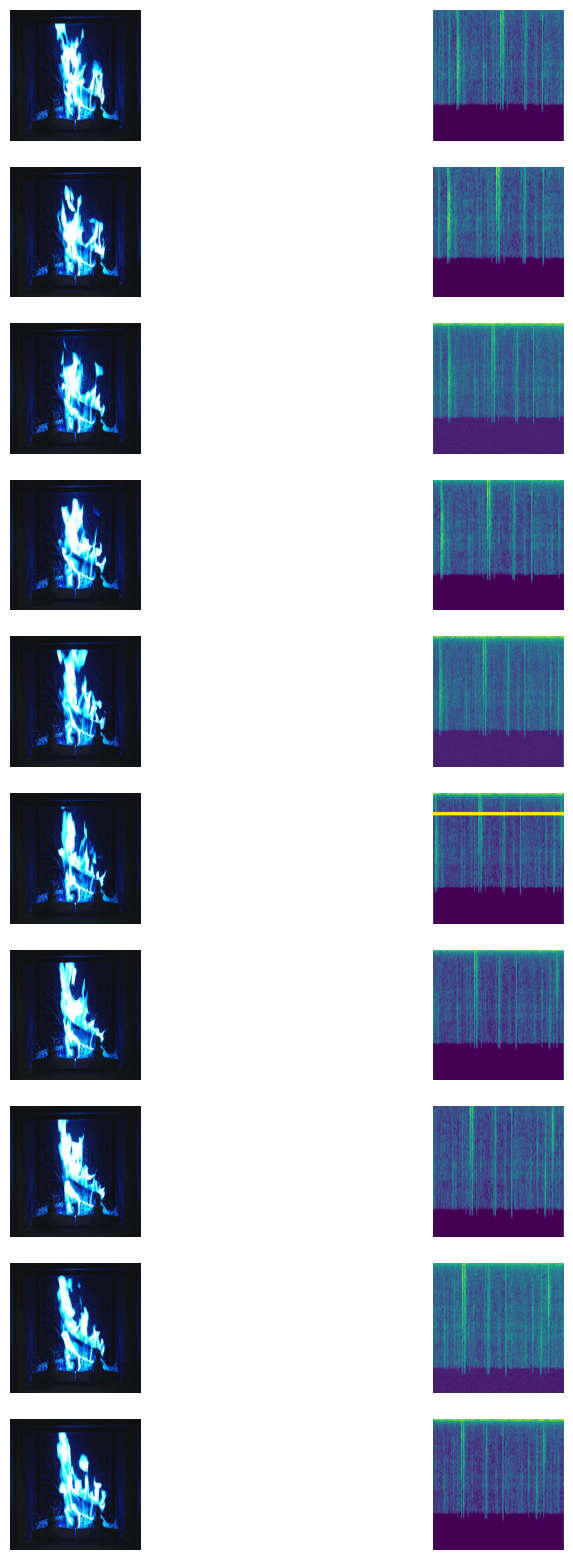

In [30]:
import matplotlib.pyplot as plt

# Function to denormalize images
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1]
    return tensor

# Get the first 10 pairs of data from the dataset
first_10_pairs = [dataset[i] for i in range(10)]

# Get the last 10 pairs of data from the dataset
last_10_pairs = [dataset[i] for i in range(-10, 0)]

# Plot the first 10 pairs of data
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
for i, (frame, prev_frame, spectrogram) in enumerate(first_10_pairs):
    frame = denormalize(frame.permute(1,2,0).numpy())  # Denormalize and rearrange dimensions
    spectrogram = denormalize(spectrogram.permute(1,2,0).numpy())  # Denormalize

    axs[i, 0].imshow(frame)
    axs[i, 1].imshow(spectrogram, cmap='viridis')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.show()

# Plot the last 10 pairs of data
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
for i, (frame, prev_frame, spectrogram) in enumerate(last_10_pairs):
    frame = denormalize(frame.permute(1,2,0).numpy())  # Denormalize and rearrange dimensions
    spectrogram = denormalize(spectrogram.permute(1,2,0).numpy())  # Denormalize

    axs[i, 0].imshow(frame)
    axs[i, 1].imshow(spectrogram, cmap='viridis')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.show()

GAN

In [32]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = True

        self.conv = nn.Conv2d(in_channels=self.input_channels + self.hidden_channels,
                              out_channels=4 * self.hidden_channels,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_channels, height, width).cuda(),
                torch.zeros(batch_size, self.hidden_channels, height, width).cuda())

    def apply_weights_init(self):
        self.conv.apply(weights_init_normal)

In [33]:
class UNetGenerator(nn.Module):
    def __init__(self, input_channels=4, output_channels=3, hidden_channels=512, lstm_kernel_size=3):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, dropout=0.0):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            layers.append(nn.BatchNorm2d(out_channels))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            layers.append(nn.ReLU(inplace=True))
            return nn.Sequential(*layers)

        self.down1 = down_block(input_channels, 64, batch_norm=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)
        self.down7 = down_block(512, 512)
        self.down8 = down_block(512, 512, batch_norm=False)

        self.convlstm = ConvLSTMCell(512, hidden_channels, lstm_kernel_size)

        self.up1 = up_block(hidden_channels, 512, dropout=0.5)
        self.up2 = up_block(1024, 512, dropout=0.5)
        self.up3 = up_block(1024, 512, dropout=0.5)
        self.up4 = up_block(1024, 512)
        self.up5 = up_block(1024, 256)
        self.up6 = up_block(512, 128)
        self.up7 = up_block(256, 64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128, output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

        self.attn1 = nn.Conv2d(512, 512, kernel_size=1)
        self.attn2 = nn.Conv2d(512, 512, kernel_size=1)
        self.attn3 = nn.Conv2d(512, 512, kernel_size=1)

    def forward(self, x, hidden_state=None):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        if hidden_state is None:
            hidden_state = self.convlstm.init_hidden(x.size(0), (d8.size(2), d8.size(3)))

        h, c = self.convlstm(d8, hidden_state)

        u1 = self.up1(h)
        u2 = self.up2(torch.cat([u1, self.attn1(d7)], 1))
        u3 = self.up3(torch.cat([u2, self.attn2(d6)], 1))
        u4 = self.up4(torch.cat([u3, self.attn3(d5)], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.up8(torch.cat([u7, d1], 1))

        return u8, (h, c)

# Properly initialize the weights
def weights_init_normal(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and isinstance(m.weight, torch.Tensor):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if hasattr(m, 'bias') and isinstance(m.bias, torch.Tensor):
        nn.init.constant_(m.bias.data, 0)
    if classname.find('BatchNorm') != -1 and hasattr(m, 'weight') and isinstance(m.weight, torch.Tensor):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, 'bias') and isinstance(m.bias, torch.Tensor):
            nn.init.constant_(m.bias.data, 0)



In [34]:
import torch
import torch.nn as nn

class PatchGANDiscriminator(nn.Module):
    def __init__(self, input_channels=7):
        super(PatchGANDiscriminator, self).__init__()
        
        def disc_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)
        
        self.model = nn.Sequential(
            disc_block(input_channels, 64, batch_norm=False),  # First layer should match input_channels
            disc_block(64, 128),
            disc_block(128, 256),
            disc_block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [42]:
# Initialize models
netG = UNetGenerator(input_channels=hparams['input_channels'], output_channels=hparams['output_channels']).to(device)
netD = PatchGANDiscriminator(input_channels=hparams['input_channels'] + hparams['output_channels']).to(device)

# Apply weight initialization
netG.apply(weights_init_normal)
netD.apply(weights_init_normal)

# Initialize weights for ConvLSTMCell within UNetGenerator
netG.convlstm.apply_weights_init()

# Initialize optimizers
optimizerG = optim.Adam(netG.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])
optimizerD = optim.Adam(netD.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

# Perceptual Loss
import torchvision.models as models

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        self.layers = nn.Sequential(*list(vgg[:36])).eval()
        for param in self.layers.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        input_features = self.layers(input)
        target_features = self.layers(target)
        return nn.functional.mse_loss(input_features, target_features)

# Initialize loss functions
criterion_gan = nn.BCELoss()
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)

Train

Epoch [0/5], Step [0/16172], Loss D: 0.5084, Loss G: 13.9930
Validation Loss G: 16.4371
Epoch [0/5], Step [2000/16172], Loss D: 0.5691, Loss G: 10.7347
Validation Loss G: 14.9736
Epoch [0/5], Step [4000/16172], Loss D: 0.6444, Loss G: 9.8527
Validation Loss G: 13.3048
Epoch [0/5], Step [6000/16172], Loss D: 0.6139, Loss G: 11.3872
Validation Loss G: 12.9245
Epoch [0/5], Step [8000/16172], Loss D: 0.5889, Loss G: 11.0450
Validation Loss G: 13.4084
Epoch [0/5], Step [10000/16172], Loss D: 0.7579, Loss G: 9.4273
Validation Loss G: 12.1618
Epoch [0/5], Step [12000/16172], Loss D: 0.5395, Loss G: 11.1843
Validation Loss G: 14.6753
Epoch [0/5], Step [14000/16172], Loss D: 0.6140, Loss G: 10.6014
Validation Loss G: 13.0750
Epoch [0/5], Step [16000/16172], Loss D: 0.6264, Loss G: 12.3839
Validation Loss G: 12.7738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


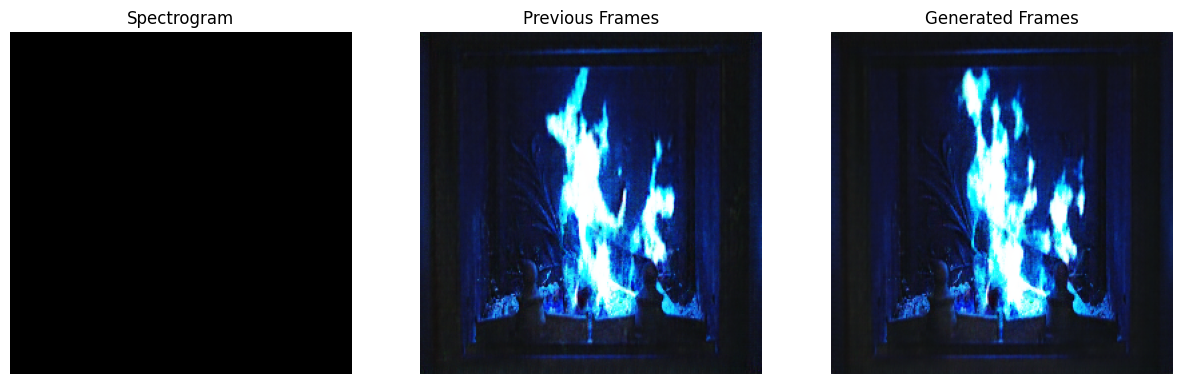

Epoch [1/5], Step [0/16172], Loss D: 0.6975, Loss G: 10.8079
Validation Loss G: 13.8378
Epoch [1/5], Step [2000/16172], Loss D: 0.6016, Loss G: 9.8212
Validation Loss G: 13.2440
Epoch [1/5], Step [4000/16172], Loss D: 0.5150, Loss G: 12.2590
Validation Loss G: 15.5182
Epoch [1/5], Step [6000/16172], Loss D: 0.7205, Loss G: 12.7215
Validation Loss G: 14.7492


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Define the probability to use generated frames
use_generated_frames_prob = 0.95

netG.train()  # Set the model to training mode

# Lists to store the losses
losses_G = []
losses_D = []
val_losses_G = []
val_iteration_steps = []

# Training loop
for epoch in range(hparams['num_epochs']):
    for i, (real_frames, prev_frames, spectrograms) in enumerate(dataloader):
        real_frames = real_frames.to(device)
        prev_frames = prev_frames.to(device)
        spectrograms = spectrograms.to(device)

        # Ensure the spectrograms have the correct channel dimension
        # Spectrograms already have (N, 1, H, W)
        # Real and previous frames already have (N, C, H, W)

        # Initialize hidden state for ConvLSTM
        hidden_state = None

        # Initial input: concatenate previous frames with spectrograms
        inputs = torch.cat((spectrograms, prev_frames), dim=1)  # (N, 4, H, W)

        # List to store generated frames for potential future use
        generated_frames = []

        # Generate fake frames
        fake_frames, hidden_state = netG(inputs, hidden_state)

        # Store the generated frames
        generated_frames.append(fake_frames)

        # Decide whether to use generated frames or real previous frames
        use_generated = random.random() < use_generated_frames_prob

        if use_generated and len(generated_frames) > 1:
            prev_frames = generated_frames[-1]  # Use the last generated frame as the previous frame
        else:
            prev_frames = prev_frames  # Use the real previous frame

        # Concatenate the new previous frame with the current spectrogram
        inputs = torch.cat((spectrograms, prev_frames), dim=1)

        # Forward pass real frames through D to determine the output size
        with torch.no_grad():
            real_inputs = torch.cat((inputs, real_frames), 1)  # (N, 7, H, W)
            output_real = netD(real_inputs)
            label_shape = output_real.shape  # Get the shape of the discriminator output

        # Create labels with the correct shape
        real_labels = torch.ones(label_shape).to(device)
        fake_labels = torch.zeros(label_shape).to(device)

        # ----------------------
        # Update Discriminator
        # ----------------------
        optimizerD.zero_grad()

        # Forward pass real frames through D
        output_real = netD(real_inputs)
        lossD_real = criterion_gan(output_real, real_labels)

        # Forward pass fake frames through D
        fake_inputs = torch.cat((inputs, fake_frames.detach()), 1)  # (N, 7, H, W)
        output_fake = netD(fake_inputs)
        lossD_fake = criterion_gan(output_fake, fake_labels)

        # Compute total discriminator loss
        lossD = (lossD_real + lossD_fake) * 0.5
        lossD.backward()
        optimizerD.step()

        # ------------------
        # Update Generator
        # ------------------
        optimizerG.zero_grad()

        # Forward pass fake frames through D
        fake_inputs = torch.cat((inputs, fake_frames), 1)  # (N, 7, H, W)
        output_fake = netD(fake_inputs)
        loss_gan = criterion_gan(output_fake, real_labels)
        loss_l1 = criterion_l1(fake_frames, real_frames)
        loss_perceptual = criterion_perceptual(fake_frames, real_frames)

        lossG = (loss_gan * 5 + loss_l1 * 50 + loss_perceptual * 10)

        lossG.backward()
        optimizerG.step()

        # Append losses to lists
        losses_G.append(lossG.item())
        losses_D.append(lossD.item())

        # Print statistics and validate
        if i % 2000 == 0:
            print(f'Epoch [{epoch}/{hparams["num_epochs"]}], Step [{i}/{len(dataloader)}], '
                  f'Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}')
            
            # Validation step
            netG.eval()  # Set the model to evaluation mode
            val_lossG = 0.0
            with torch.no_grad():
                for val_real_frames, val_prev_frames, val_spectrograms in val_loader:
                    val_real_frames = val_real_frames.to(device)
                    val_prev_frames = val_prev_frames.to(device)
                    val_spectrograms = val_spectrograms.to(device)

                    val_inputs = torch.cat((val_spectrograms, val_prev_frames), dim=1)  # (N, 4, H, W)
                    val_fake_frames, _ = netG(val_inputs, hidden_state)
                    
                    val_loss_gan = criterion_gan(netD(torch.cat((val_inputs, val_fake_frames), 1)), real_labels)
                    val_loss_l1 = criterion_l1(val_fake_frames, val_real_frames)
                    val_loss_perceptual = criterion_perceptual(val_fake_frames, val_real_frames)
                    
                    val_lossG += (val_loss_gan * 5 + val_loss_l1 * 50 + val_loss_perceptual * 10).item()
            
            val_lossG /= len(val_loader)  # Average validation loss
            val_losses_G.append(val_lossG)
            val_iteration_steps.append(epoch * len(dataloader) + i)
            print(f'Validation Loss G: {val_lossG:.4f}')
            netG.train()  # Set the model back to training mode

    # Visualize input and output images
    with torch.no_grad():
        # Randomly select a batch from the dataloader
        random_batch = next(iter(dataloader))
        prev_frames_batch = generated_frames[-1]
        spectrograms_batch = random_batch[2][:hparams['num_val_samples']].to(device)
        fake_frames_batch, _ = netG(torch.cat((spectrograms_batch, prev_frames_batch), dim=1))

        # Denormalize the images for visualization
        prev_frames_denorm = denormalize(prev_frames_batch)
        fake_frames_denorm = denormalize(fake_frames_batch)

        # Create grids of images
        spect_grid = make_grid(spectrograms_batch, nrow=hparams['num_val_samples'])
        prev_img_grid = make_grid(prev_frames_denorm, nrow=hparams['num_val_samples'])
        fake_img_grid = make_grid(fake_frames_denorm, nrow=hparams['num_val_samples'])

        # Plot the image grids
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.title('Spectrogram')
        plt.imshow(spect_grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Previous Frames')
        plt.imshow(prev_img_grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Generated Frames')
        plt.imshow(fake_img_grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')

        plt.show()

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.plot(val_iteration_steps, val_losses_G, label='Validation Generator Loss', marker='o')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator, Discriminator, and Validation Generator Losses')
plt.legend()
plt.grid(True)
plt.show()

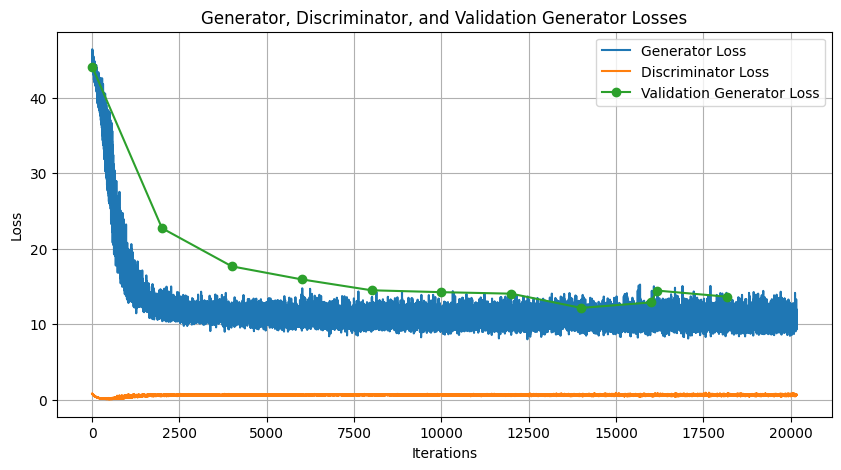

In [44]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.plot(val_iteration_steps, val_losses_G, label='Validation Generator Loss', marker='o')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator, Discriminator, and Validation Generator Losses')
plt.legend()
plt.grid(True)
plt.show()

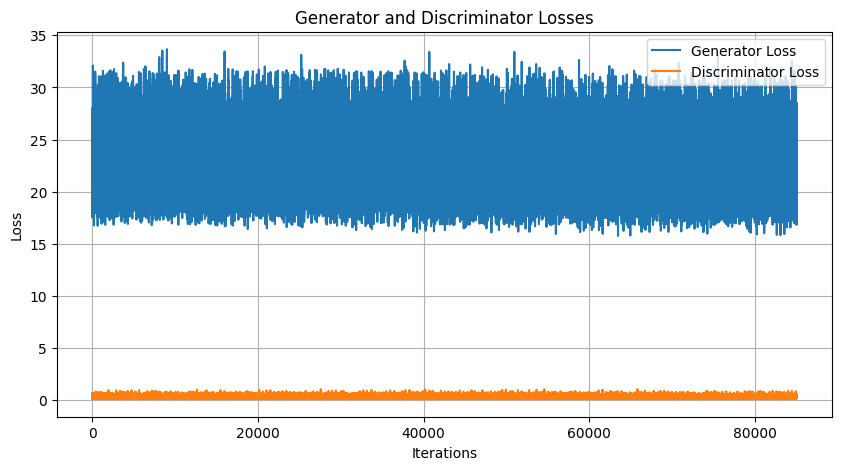

In [55]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.grid(True)
plt.show()

Save model

In [45]:
# Save the model weights
torch.save(netG.state_dict(), 'model_weights_V5_4.pth')

Load model

In [28]:
import torch
from torchvision.utils import save_image, make_grid

# Assuming UNetGenerator is defined as above
# Load the model weights
netG = UNetGenerator(input_channels=4, output_channels=3)
netG.load_state_dict(torch.load('model_weights_V4_3.pth'))
netG.eval()  # Set the model to evaluation mode

UNetGenerator(
  (down1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down5): Sequential(
    (0): Conv2d(512,

Inference from new data

C:\Users\David\AppData\Local\Temp\ipykernel_8672\328201547.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame = torch.tensor(frame, dtype=torch.float32)
C:\Users\David\AppData\Local\Temp\ipykernel_8672\328201547.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram = torch.tensor(spectrogram, dtype=torch.float32)


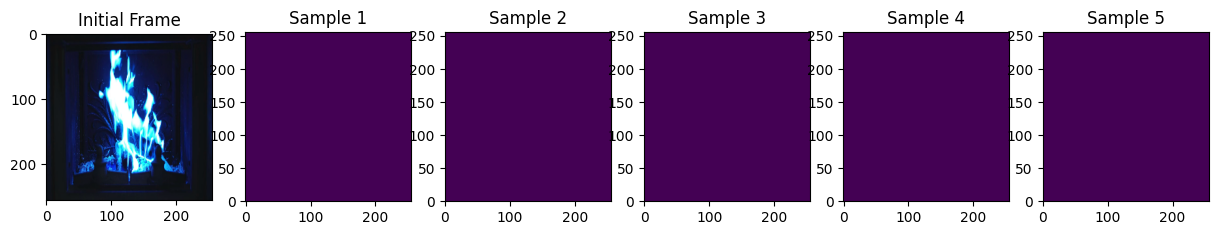

In [49]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

# Function to denormalize images
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1]
    return tensor

# Dataset definition for inference
class SpectrogramNPYDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.npy_files = [f for f in os.listdir(folder_path) if f.endswith('_spectrogram.npy')]
        self.transform = transform  # Assign the transform function
        
        # Load initial frame

        
        

        self.initial_frame = self.load_initial_frame()

    def load_initial_frame(self):
        frame_files = [f for f in os.listdir(self.folder_path) if f.endswith('_frame.npy')]
        if len(frame_files) == 0:
            raise FileNotFoundError("No initial frame found in the folder.")
        frame_path = os.path.join(self.folder_path, frame_files[0])
        frame = np.load(frame_path)
        frame = torch.from_numpy(frame.astype(np.float32)).permute(2, 0, 1)
        frame = torch.tensor(frame, dtype=torch.float32)
        frame = (frame / 127.5) - 1  # Normalize to [-1, 1]
        
        return frame

    def __len__(self):
        return len(self.npy_files)
    
    def __getitem__(self, idx):
        npy_name = os.path.join(self.folder_path, self.npy_files[idx])
        spectrogram = np.load(npy_name)

        # Ensure it has the channel dimension
        spectrogram = torch.from_numpy(spectrogram.astype(np.float32)).unsqueeze(0)  # Add channel dimension
        
        spectrogram = transform(spectrogram)

        spectrogram = torch.tensor(spectrogram, dtype=torch.float32)

        # Normalize to [-1, 1]
        spectrogram = (spectrogram / 127.5) - 1

        
        
        return spectrogram, self.initial_frame

# Define the transformation

transform = transforms.Compose([
    transforms.RandomVerticalFlip(p=0),  # p=1.0 ensures the flip always happens
])

# Create the dataset and dataloader for inference
folder_path = 'C:/Users/David/Documents/postgrau/Projecte/raining/frames/Inference Spectrograms'
inference_dataset = SpectrogramNPYDataset(folder_path, transform=transform)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False)

# Visualize a few spectrograms and the initial frame
def visualize_spectrograms(dataset, num_samples=5):
    plt.figure(figsize=(15, 2.2))
    
    # Plot initial frame
    initial_frame = dataset.initial_frame.permute(1, 2, 0).numpy()
    initial_frame = (initial_frame + 1) * 127.5  # Denormalize
    plt.subplot(1, num_samples + 1, 1)
    plt.imshow(initial_frame.astype(np.uint8))
    plt.title('Initial Frame')

    for i in range(num_samples):
        spectrogram, _ = dataset[i]
        spectrogram = spectrogram.squeeze().numpy()
        plt.subplot(1, num_samples + 1, i + 2)
        plt.imshow(spectrogram, aspect='auto', origin='lower')
        plt.title(f'Sample {i+1}')
    
    plt.show()

visualize_spectrograms(inference_dataset, num_samples=5)


C:\Users\David\AppData\Local\Temp\ipykernel_8672\328201547.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram = torch.tensor(spectrogram, dtype=torch.float32)


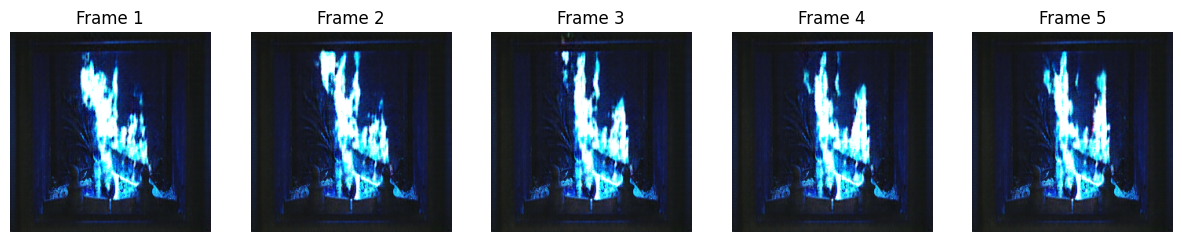

In [50]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import os

# Ensure consistent normalization/denormalization functions
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Assuming normalization to [-1, 1] range during training

netG.train()  # Set the model to training mode

# Move model to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
netG.to(device)

# Create a directory to save individual frames if it doesn't exist
os.makedirs('results/individual_frames', exist_ok=True)

# Perform inference and save the generated frames
with torch.no_grad():
    # Load the initial frame
    fake_frame = inference_dataset.initial_frame.to(device).unsqueeze(0)

    # Process each batch in the inference loader
    for batch_idx, (spectrograms, initial_frame) in enumerate(inference_loader):
        spectrograms = spectrograms.to(device)  # Move spectrograms to the correct device

        # Initialize the previous frame with the initial frame
        previous_frame = fake_frame

        # Initialize hidden state for ConvLSTM
        hidden_state = None

        # Process each spectrogram in the batch
        for i, spectrogram in enumerate(spectrograms):
            # Generate fake frame
            fake_frame, hidden_state = netG(torch.cat((spectrogram.unsqueeze(0), previous_frame), dim=1), hidden_state)
            fake_frame_denorm = denormalize(fake_frame)  # Denormalize the generated frame

            # Save the generated frame
            save_image(fake_frame_denorm.squeeze(), f'results/individual_frames/frame_{batch_idx * inference_loader.batch_size + i + 1}.png')

            # Update the previous frame for the next iteration
            previous_frame = fake_frame

# Visualize the first few results
def visualize_generated_frames(folder_path, num_samples=5):
    plt.figure(figsize=(15, 2.7))
    for i in range(num_samples):
        frame_path = os.path.join(folder_path, f'frame_{i + 1}.png')
        frame = plt.imread(frame_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(frame)
        plt.title(f'Frame {i + 1}')
        plt.axis('off')
    plt.show()

visualize_generated_frames('results/individual_frames', num_samples=5)
        

Make video

In [51]:
%pip install opencv-python

import os
import cv2

# Directory containing the frames
frames_dir = 'results/individual_frames'

# Path to save the video
video_path = 'results/output_video_16.mp4'

# Frames per second
fps = 30

# Get the list of all frame files and sort them numerically
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.png')],
                     key=lambda x: int(x.split('_')[1].split('.')[0]))

# Read the first frame to get the dimensions
first_frame = cv2.imread(os.path.join(frames_dir, frame_files[0]))
height, width, layers = first_frame.shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

# Write each frame to the video
for frame_file in frame_files:
    frame_path = os.path.join(frames_dir, frame_file)
    frame = cv2.imread(frame_path)
    video.write(frame)

# Release the VideoWriter object
video.release()

print(f'Video saved at {video_path}')


Note: you may need to restart the kernel to use updated packages.
Video saved at results/output_video_16.mp4
